In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn
from skimage.feature import hog
import json
from googleplaces import GooglePlaces, types, lang
import re
import requests
import os
import zipfile
import pickle
import math
import matplotlib.image as mpimg
import argparse
import warnings
import datetime
import dropbox
import time

In [2]:
classifier2 = pickle.load(open('final_model.pkl', 'rb'))

In [3]:
def GetFeaturesFromHog(image,orient,cellsPerBlock,pixelsPerCell, visualise= False, feature_vector_flag=True):
    if(visualise==True):
        hog_features, hog_image = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=True, feature_vector=feature_vector_flag)
        return hog_features, hog_image
    else:
        hog_features = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=False, feature_vector=feature_vector_flag)
        return hog_features

In [4]:
def ExtractFeatures(images,orientation,cellsPerBlock,pixelsPerCell,convertColorspace=False):
    featureList=[]
    imageList=[]
    for image in images:
        if(convertColorspace==True):
            image=cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        local_features0=GetFeaturesFromHog(image[:,:,0],orientation,cellsPerBlock,pixelsPerCell,False,True)
        local_features1=GetFeaturesFromHog(image[:,:,1],orientation,cellsPerBlock,pixelsPerCell,False,True)
        local_features2=GetFeaturesFromHog(image[:,:,2],orientation,cellsPerBlock,pixelsPerCell,False,True)
        x=np.hstack((local_features0,local_features1,local_features2))
        featureList.append(x)
    return featureList

In [5]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    
    for bbox in bboxes:
        r=rn.randint(0,255)
        g=rn.randint(0,255)
        b=rn.randint(0,255)
        color=(r,g,b)
        cv2.rectangle(imcopy,bbox[0],bbox[1],color,thick)
    return imcopy

In [6]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.9, 0.9)):
    if x_start_stop[0] == None:
        x_start_stop[0]=0
    if x_start_stop[1] == None:
        x_start_stop[1]=img.shape[1]
    if y_start_stop[0] ==  None:
        y_start_stop[0]= 0
    if y_start_stop[1] ==  None:
        y_start_stop[1]=img.shape[0]
    
    window_list = []
    image_width_x= x_start_stop[1] - x_start_stop[0]
    image_width_y= y_start_stop[1] - y_start_stop[0]
    
    windows_x = np.int( 1 + (image_width_x - xy_window[0])/(xy_window[0] * xy_overlap[0]))
    windows_y = np.int( 1 + (image_width_y - xy_window[1])/(xy_window[1] * xy_overlap[1]))

    modified_window_size= xy_window
    for i in range(0,windows_y):
        y_start = y_start_stop[0] + np.int( i * modified_window_size[1] * xy_overlap[1])
        for j in range(0,windows_x):
            x_start = x_start_stop[0] + np.int( j * modified_window_size[0] * xy_overlap[0])
            
            x1 = np.int( x_start +  modified_window_size[0])
            y1= np.int( y_start + modified_window_size[1])
            window_list.append(((x_start,y_start),(x1,y1)))
    return window_list

In [7]:
def drawCars(image, windows, converColorspace=False):
    refinedWindows=[]
    for window in windows:
        start=window[0]
        end=window[1]     
        clippedImage=image[start[1]:end[1], start[0]:end[0]]
        if(clippedImage.shape[1]==clippedImage.shape[0] and clippedImage.shape[1]!=0):
            clippedImage=cv2.resize(clippedImage, (64,64))
            f1=ExtractFeatures([clippedImage], 9 , 2 , 16,converColorspace)
            predictedOutput=classifier2.predict([f1[0]])
            if(predictedOutput==1):
                refinedWindows.append(window)    
    return refinedWindows        

('Total No of windows are ', 92)


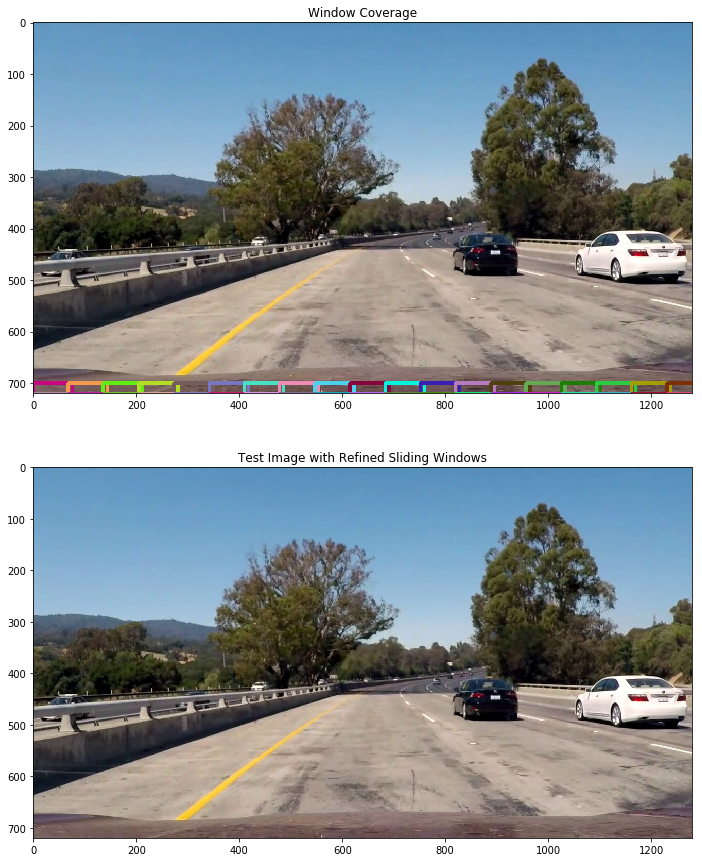

In [9]:
image = mpimg.imread('frame8.JPG')

windows1 = slide_window(image, x_start_stop=[0,1600], y_start_stop=[650,700], 
                    xy_window=(96,96), xy_overlap=(0.6, 0.6))
windows4 = slide_window(image, x_start_stop=[0,1600 ], y_start_stop=[600,700], 
                    xy_window=(128,128), xy_overlap=(0.5, 0.4))
windows2 = slide_window(image, x_start_stop=[0, 1600], y_start_stop=[750,800], 
                    xy_window=(96,96), xy_overlap=(0.6, 0.6))
windows3 = slide_window(image, x_start_stop=[0, 1600], y_start_stop=[700,850], 
                    xy_window=(76,76), xy_overlap=(0.9, 0.3))

windows = windows1 + windows2 +  windows3 + windows4
print("Total No of windows are ",len(windows))

refinedWindows=drawCars(image,windows, True)

f,axes= plt.subplots(2,1, figsize=(30,15))

window_img = draw_boxes(image, windows) 

axes[0].imshow(window_img)
axes[0].set_title("Window Coverage")

window_img = draw_boxes(image, refinedWindows) 

axes[1].set_title("Test Image with Refined Sliding Windows")
axes[1].imshow(window_img)

In [10]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap 

In [11]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [12]:
from scipy.ndimage.measurements import label
def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

In [13]:
class KeepTrack():
    def __init__(self):
        self.refinedWindows = [] 
        
    def AddWindows(self, refinedWindow):
        self.refinedWindows.append(refinedWindow)
        frameHistory=15
        if len(self.refinedWindows) > frameHistory:
            self.refinedWindows = self.refinedWindows[len(self.refinedWindows)-frameHistory:]

In [14]:
orientation=9 # No of orientations of HOG
cellsPerBlock=2 # No of cells per block
pixelsPerCell=16 # No of pixels per cell
xy_window=(96, 96) # window Size
xy_overlap=(0.6, 0.6) # Window Overlap. Please note this is different as provided by Udacity. Overlap of 0.15 means my windows are 85% overlapping with each other
x_start_stop=[0, 1600] # X Coordinates to start and stop search
y_start_stop=[650, 700] # Y Coordinates to start and stop search

# Window 1- Size - 64x64 , Overlap-85%
windows_normal = slide_window(image, x_start_stop, [650,700], 
                    xy_window, xy_overlap)

# Window 2- Size - 80x80 , Overlap-80%
xy_window_1_25= (96,96)
xy_window_1_25_overlap=(0.6, 0.6)    
windows_1_25 = slide_window(image, x_start_stop, [750,800], 
                    xy_window_1_25, xy_window_1_25_overlap)

# Window 3- Size - 96x96 , Overlap-70%
xy_window_1_5= (76,76)
xy_window_1_5_overlap=(0.9, 0.3)    
windows_1_5 = slide_window(image, x_start_stop, [700,850], 
                    xy_window_1_5, xy_window_1_5_overlap)

# Window 4- Size - 128x128 , Overlap-50%
xy_window_twice_overlap=(0.5, 0.4)    
xy_window_twice = (128,128)
windows_twice = slide_window(image, x_start_stop, [600,700], 
                    xy_window_twice, xy_window_twice_overlap)

# Total Windows - 470
windows= windows_normal +  windows_1_5  + windows_twice +windows_1_25
print("No of Windows are ",len(windows))

('No of Windows are ', 92)


In [15]:
def Pipeline(image):
    rand= rn.randint(0,1)
    if(rand<0.4):
        refinedWindows=keepTrack.refinedWindows[:-1]
    else:
        refinedWindows=drawCars(image,windows, True)
        if len(refinedWindows) > 0:
            keepTrack.AddWindows(refinedWindows)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for refinedWindow in keepTrack.refinedWindows:
        heat = add_heat(heat, refinedWindow)
    heatmap = apply_threshold(heat, 25 + len(keepTrack.refinedWindows)//2)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [16]:
def PipelineImage(image):
    refinedWindows=drawCars(image,windows, True)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,refinedWindows)
    heatmap = np.clip(heat, 0, 255)
    heatmap = apply_threshold(heat, 0)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img,heatmap,labels

In [17]:
conf = json.load(open('config.json'))
client = None
client = dropbox.Dropbox(conf["dropbox_access_token"])
print("[SUCCESS] dropbox account linked")

[SUCCESS] dropbox account linked


In [21]:
cap = cv2.VideoCapture('college.avi')
frameRate = cap.get(5)
count = 0
name=""   
while (cap.isOpened()):
        frameId = cap.get(1)
        # Capture frame-by-frame
        ret, frame = cap.read()
 
        if ret != True:
            break
        if (frameId % (5*math.floor(frameRate)) == 0):
            print('Read %d frame: ' % count, ret)
            name="car.jpg"
            cv2.imwrite(name, frame)  # save frame as JPEG file
            image=cv2.imread(name)
            count=count+1
            finalPic,heatmap, labels = PipelineImage(image)
            
            from geopy.geocoders import Nominatim
            geolocator = Nominatim(user_agent="specify_your_app_name_here")
            location = geolocator.reverse(latlong[count-1])
            a=location.raw['address']
            town = a.get('suburb', None)

            zip = zipfile.ZipFile('%s.zip'%(str(town)),'w') 
            zip.write("car.jpg")

            from gtts import gTTS
            import os
            tts = gTTS(text='The number of cars present is %d'%labels[1], lang='en')
            tts.save("cars.mp3")
            zip.write('cars.mp3')

            f=open("Car Information.txt","w+")
            f.write("The number of cars present is:%d"%labels[1])
            f.close()
            zip.write('Car Information.txt')
            zip.close()
            path = "/%s.zip"%(str(town)).format( base_path=conf["dropbox_base_path"])
            client.files_upload(open('%s.zip'%(str(town)), "rb").read(), path)
            os.remove('car.jpg')
            os.remove('cars.mp3')
            os.remove('Car Information.txt')
            os.remove('%s.zip'%(str(town)))    

('Read 0 frame: ', True)


C:\Users\dell\Anaconda2_32bit_2.7\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\Users\dell\Anaconda2_32bit_2.7\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


('Read 1 frame: ', True)
('Read 2 frame: ', True)
('Read 3 frame: ', True)
('Read 4 frame: ', True)
('Read 5 frame: ', True)
('Read 6 frame: ', True)
('Read 7 frame: ', True)


In [65]:
print(count)

2


In [25]:
zip.close()

In [39]:
image=cv2.imread('car_%d'%(count-1))

In [18]:
latlong=[["12.751016, 80.198109"],["12.979798,80.186566"],["12.922915,80.127457"],["12.897470,80.088333"],["12.963800,80.244423"],["12.983027,80.259399"], ["13.11760,80.221481"],["13.073226,80.260918"],["13.107280,80.292953"],["12.834174, 79.703644"],["12.985910,80.175194"]]

In [63]:
name

'car_0.jpg'

In [64]:
print(image)

[[[183 144 105]
  [188 149 110]
  [186 147 108]
  ...
  [171 127  86]
  [172 128  87]
  [173 129  88]]

 [[184 145 106]
  [188 149 110]
  [186 147 108]
  ...
  [170 126  85]
  [171 127  86]
  [171 127  86]]

 [[184 146 104]
  [188 150 108]
  [186 147 108]
  ...
  [169 126  83]
  [168 125  82]
  [168 125  82]]

 ...

 [[ 75  82 102]
  [ 73  80 100]
  [ 76  83 103]
  ...
  [ 61  61  85]
  [ 67  67  91]
  [ 73  73  97]]

 [[ 73  82 102]
  [ 71  80 100]
  [ 74  83 103]
  ...
  [ 55  55  79]
  [ 56  56  80]
  [ 60  60  84]]

 [[ 73  82 102]
  [ 70  79  99]
  [ 72  81 101]
  ...
  [ 55  55  79]
  [ 53  53  77]
  [ 57  57  81]]]


In [38]:
path = "/Siruseri.zip".format( base_path=conf["dropbox_base_path"])

In [39]:
client.files_delete(path)

FileMetadata(name=u'Siruseri.zip', id=u'id:TBZDu9rzwHUAAAAAAAABHw', client_modified=datetime.datetime(2019, 2, 26, 6, 39, 3), server_modified=datetime.datetime(2019, 2, 26, 6, 39, 3), rev=u'016e000000012525d280', size=205380, path_lower=u'/siruseri.zip', path_display=u'/Siruseri.zip', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, property_groups=None, has_explicit_shared_members=None, content_hash=u'802670c1928e74d6f5ac0102a8cae119e6b1764560532f6622e2b3e9bb2174bf')

In [1]:
import os
os.remove('Truck.jpg')